## Practice: Basic Artificial Neural Networks
Credits: this notebook belongs to [Practical DL](https://docs.google.com/forms/d/e/1FAIpQLScvrVtuwrHSlxWqHnLt1V-_7h2eON_mlRR6MUb3xEe5x9LuoA/viewform?usp=sf_link) course by Yandex School of Data Analysis.

We will start working with neural networks on the practice session. Your homework will be to finish the implementation of the layers.

Our goal is simple, yet an actual implementation may take some time :). We are going to write an Artificial Neural Network (almost) from scratch. The software design was heavily inspired by [PyTorch](http://pytorch.org) which is the main framework of our course 

Speaking about the homework (once again, it will be really similar to this seminar), it requires sending **multiple** files, please do not forget to include all the files when sending to TA. The list of files:
- This notebook
- modules.ipynb with all blocks implemented (except maybe `Conv2d` and `MaxPool2d` layers implementation which are part of 'advanced' version of this homework)

In [1]:
%matplotlib inline
from time import time, sleep

import numpy as np

from sklearn.preprocessing import OneHotEncoder


import matplotlib.pyplot as plt
from IPython import display

# Framework

Implement everything in `modules.ipynb`. Read all the comments thoughtfully to ease the pain. Please try not to change the prototypes.

Do not forget, that each module should return **AND** store `output` and `gradInput`.

The typical assumption is that `module.backward` is always executed after `module.forward`,
so `output` is stored, this would be useful for `SoftMax`. 

### Tech note
Prefer using `np.multiply`, `np.add`, `np.divide`, `np.subtract` instead of `*`,`+`,`/`,`-` for better memory handling.

Example: suppose you allocated a variable 

```
a = np.zeros(...)
```
So, instead of
```
a = b + c  # will be reallocated, GC needed to free
``` 
You can use: 
```
np.add(b,c,out = a) # puts result in `a`
```

In [65]:
# (re-)load layers
%run modules.ipynb

# Toy example

Use this example to debug your code, start with logistic regression and then test other layers. You do not need to change anything here. This code is provided for you to test the layers. Also it is easy to use this code in MNIST task.

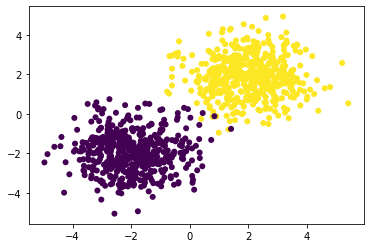

In [3]:
# Generate some data
N = 500

X1 = np.random.randn(N,2) + np.array([2,2])
X2 = np.random.randn(N,2) + np.array([-2,-2])

Y = np.concatenate([np.ones(N),np.zeros(N)])[:,None]
Y = np.hstack([Y, 1-Y])

X = np.vstack([X1,X2])
plt.scatter(X[:,0],X[:,1], c = Y[:,0], edgecolors= 'none')

Define a **logistic regression** for debugging. 

In [4]:
net = Sequential()
net.add(Linear(2, 2))
net.add(LogSoftMax())

criterion = ClassNLLCriterion()

print(net)

# Test something like that then 

# net = Sequential()
# net.add(Linear(2, 4))
# net.add(ReLU())
# net.add(Linear(4, 2))
# net.add(LogSoftMax())

Linear 2 -> 2
LogSoftMax



Start with batch_size = 1000 to make sure every step lowers the loss, then try stochastic version.

In [5]:
# Iptimizer params
optimizer_config = {'learning_rate' : 1e-1, 'momentum': 0.9}
optimizer_state = {}

# Looping params
n_epoch = 20
batch_size = 128

In [6]:
# batch generator
def get_batches(dataset, batch_size):
    X, Y = dataset
    n_samples = X.shape[0]
        
    # Shuffle at the start of epoch
    indices = np.arange(n_samples)
    np.random.shuffle(indices)
    
    for start in range(0, n_samples, batch_size):
        end = min(start + batch_size, n_samples)
        
        batch_idx = indices[start:end]
    
        yield X[batch_idx], Y[batch_idx]

### Train

Basic training loop. Examine it.

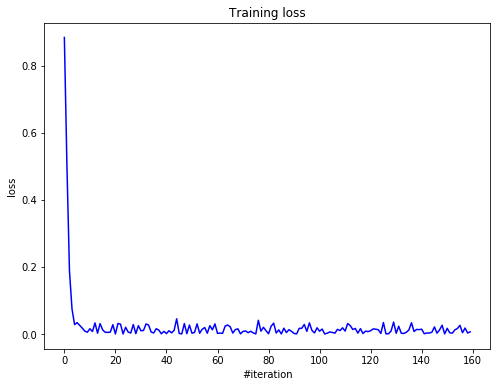

Current loss: 0.006490


In [7]:
loss_history = []

for i in range(n_epoch):
    for x_batch, y_batch in get_batches((X, Y), batch_size):
        
        net.zeroGradParameters()
        
        # Forward
        predictions = net.forward(x_batch)
        loss = criterion.forward(predictions, y_batch)
    
        # Backward
        dp = criterion.backward(predictions, y_batch)
        net.backward(x_batch, dp)
        
        # Update weights
        sgd_momentum(net.getParameters(), 
                     net.getGradParameters(), 
                     optimizer_config,
                     optimizer_state)      
        
        loss_history.append(loss)

    # Visualize
    display.clear_output(wait=True)
    plt.figure(figsize=(8, 6))
        
    plt.title("Training loss")
    plt.xlabel("#iteration")
    plt.ylabel("loss")
    plt.plot(loss_history, 'b')
    plt.show()
    
    print('Current loss: %f' % loss)    

# Digit classification 

We are using old good [MNIST](http://yann.lecun.com/exdb/mnist/) as our dataset.

In [19]:
import mnist
X_train, y_train, X_val, y_val, X_test, y_test = mnist.load_dataset(flatten=True)

One-hot encode the labels first.

In [20]:
onehot = OneHotEncoder()

y_train_oh = onehot.fit_transform(y_train.reshape(-1, 1)).toarray()
y_val_oh = onehot.fit_transform(y_val.reshape(-1, 1)).toarray()

- **Compare** `ReLU`, `ELU`, `LeakyReLU`, `SoftPlus` activation functions. 
You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.
- **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.
- Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.
- Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?
- Hint: good logloss for MNIST should be around 0.5. 

---
### Сначала определим методы для итерации батчами

In [96]:
import imgaug.augmenters as iaa

def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

def iterate_aug_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.random.permutation(len(inputs))
    for start_idx in range(0, len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx:start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        
        sometimes = lambda aug: iaa.Sometimes(0.1, aug)

        seq = Sequential([
            sometimes(iaa.Crop(px=(1, 2), keep_size=True)),
            sometimes(iaa.Affine(rotate=(-5, 5)))
        ], random_order=True)

        yield seq(images=inputs[excerpt]), targets[excerpt]

ModuleNotFoundError: No module named 'imgaug'

### Определим метод создания нейронной сети

In [82]:
def get_mlp(in_features, out_features, act, use_batchnorm=False):
    net = Sequential()
    net.add(Linear(in_features, 500))
    if use_batchnorm:
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(500))
    net.add(act())
    net.add(Linear(500, 200))
    if use_batchnorm:
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(200))
    net.add(act())
    net.add(Linear(200, out_features))
    if use_batchnorm:
        net.add(BatchNormalization())
        net.add(ChannelwiseScaling(10))
    net.add(LogSoftMax())
    return net

### Определим класс обучающейся модели

In [83]:
class Model:
    def __init__(self, net, net_name, criterion):
        self.net = net
        self.net_name = net_name
        self.criterion = criterion


    def visualize(self, independ_plot=False):
        if independ_plot:
            plt.figure(figsize=(29.7/2, 21./2))
            plt.title(f'{self.net_name}, Epoch {self.epoch}')
            plt.xlabel("Epoch number")
            plt.ylabel("Accuracy")

        plt.plot(self.train_accuracy, label=f'{self.net_name} train accuracy[{self.train_accuracy[-1]}]')
        plt.plot(self.val_accuracy, label=f'{self.net_name} validation accuracy[{self.val_accuracy[-1]}]')
        
        if independ_plot:
            plt.grid()
            plt.legend(loc='best')
            plt.show()

    def fit(self,
            X_train,
            X_val,
            y_train_oh,
            y_train,
            y_val,
            optimizer,
            n_epoch=25,
            batch_size=64,
            optimizer_config={'learning_rate' : 0.03, 'momentum': 0.9},
            optimizer_state={},
            batch_iterator=iterate_minibatches
           ):
        self.train_accuracy = []
        self.val_accuracy = []
        self.epoch = 0
        
        for self.epoch in range(n_epoch):
            self.net.train()
            for x_batch, y_batch in batch_iterator(X_train, y_train_oh, batch_size, shuffle=True):
                self.net.zeroGradParameters()
                
                # Forward
                predictions = self.net.forward(x_batch)
                loss = self.criterion.forward(predictions, y_batch)
            
                # Backward
                dp = self.criterion.backward(predictions, y_batch)
                self.net.backward(x_batch, dp)
                
                # Update weights
                optimizer(self.net.getParameters(), 
                            self.net.getGradParameters(), 
                            optimizer_config,
                            optimizer_state)      
            self.net.evaluate()

            # Predict for learning curves
            predictions_train = self.net.forward(X_train).argmax(axis=-1)
            predictions_val = self.net.forward(X_val).argmax(axis=-1)
            self.train_accuracy.append(np.mean(predictions_train == y_train))
            self.val_accuracy.append(np.mean(predictions_val == y_val))
            
            # Visualize
            display.clear_output(wait=True)
            self.visualize(independ_plot=True)

        return self 

        def predict(self, input):
            self.net.evaluate()
            return self.net.forward(X_test).argmax(axis=-1)

### Перейдём к исследованию

Во всех заданиях далее я буду измерять качество моделей не с помощью logloss, а при помощи accuracy, так как эта метрика лучше указывает на переобучение 

> Compare ReLU, ELU, LeakyReLU, SoftPlus activation functions. You would better pick the best optimizer params for each of them, but it is overkill for now. Use an architecture of your choice for the comparison.

In [14]:
%%time

act_methods = {
    'relu' : [ReLU, None],
    'elu' : [ELU, None],
    'leaky_relu' : [LeakyReLU, None],
    'soft_plus' : [SoftPlus, None],
}
for k, v in act_methods.items():
    net = get_mlp(X_train.shape[1], 10, v[0])
    model = Model(net, k, ClassNLLCriterion())
    v[1] = model.fit(X_train, X_val, y_train_oh, y_train, y_val, sgd_momentum)
display.clear_output(wait=True)

CPU times: user 52min 59s, sys: 2min 6s, total: 55min 5s
Wall time: 15min 7s


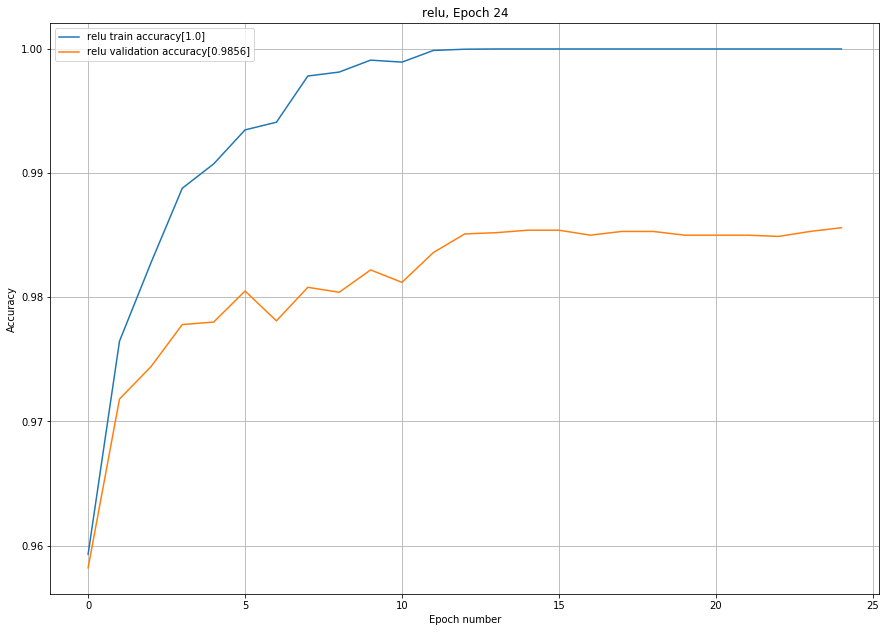

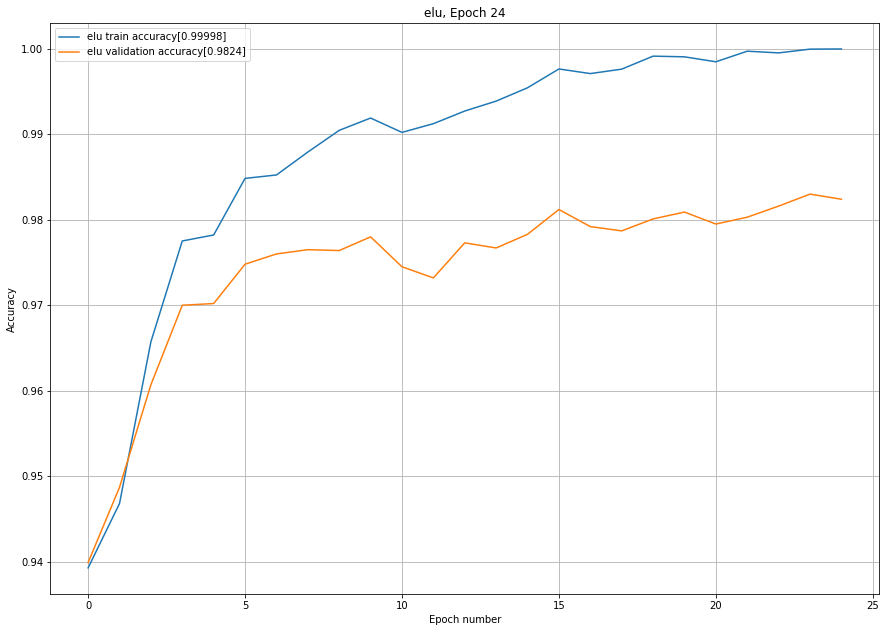

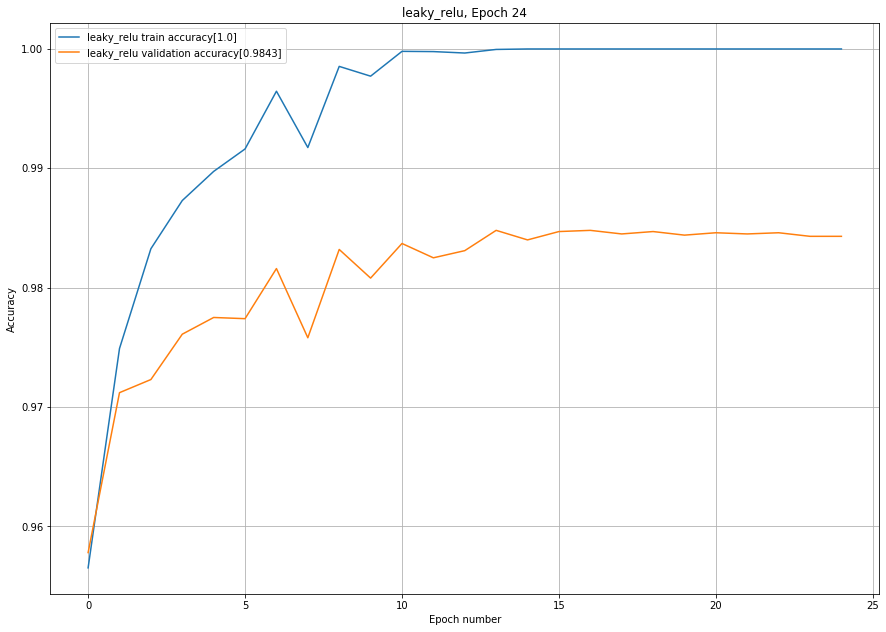

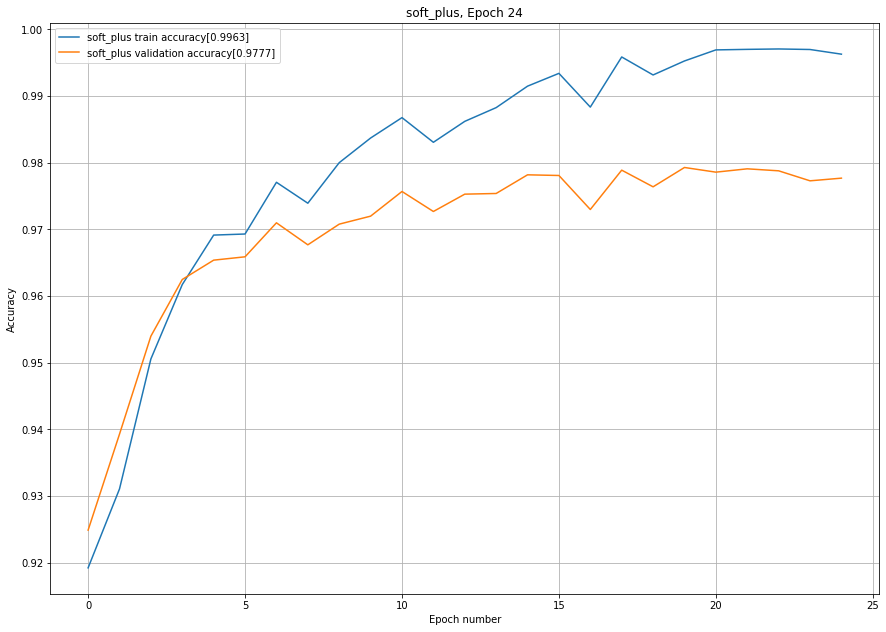

In [16]:
for _, v in act_methods.items():
    v[1].visualize(independ_plot=True)

> **Try** inserting `BatchNormalization` (folowed by `ChannelwiseScaling`) between `Linear` module and activation functions.

> Plot the losses both from activation functions comparison and `BatchNormalization` comparison on one plot. Please find a scale (log?) when the lines are distinguishable, do not forget about naming the axes, the plot should be goodlooking.

In [76]:
%%time
act_bn_methods = {
    'relu' : [ReLU, None],
    'elu' : [ELU, None],
    'leaky_relu' : [LeakyReLU, None],
    'soft_plus' : [SoftPlus, None],
}

for k, v in act_bn_methods.items():
    net = get_mlp(X_train.shape[1], 10, v[0], use_batchnorm=True)
    model = Model(net, k + ' with_bn', ClassNLLCriterion())
    v[1] = model.fit(X_train, X_val, y_train_oh, y_train, y_val, sgd_momentum, optimizer_config={'learning_rate' : 0.1, 'momentum': 0.9})
    
display.clear_output(wait=True)

CPU times: user 1h 4min 34s, sys: 2min 29s, total: 1h 7min 4s
Wall time: 18min 33s


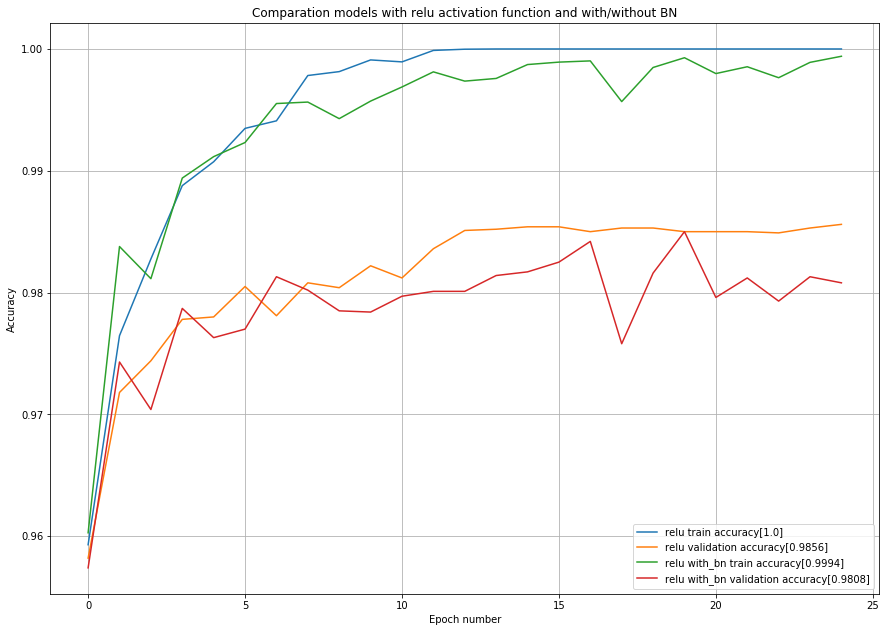

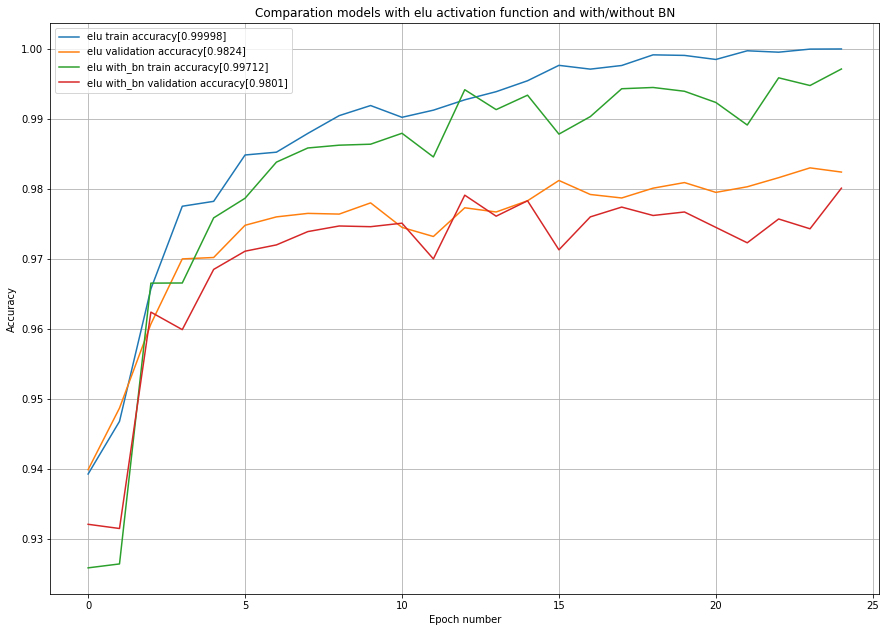

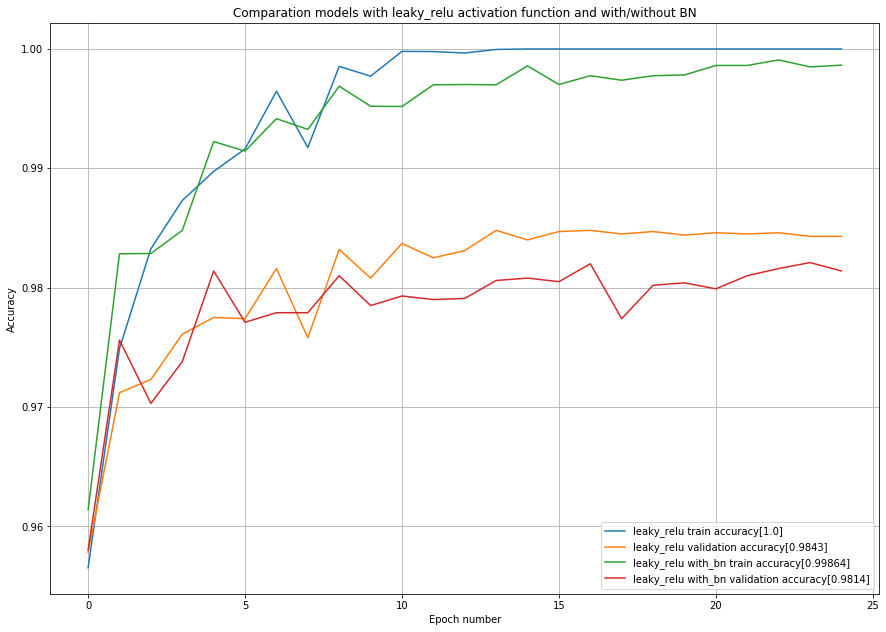

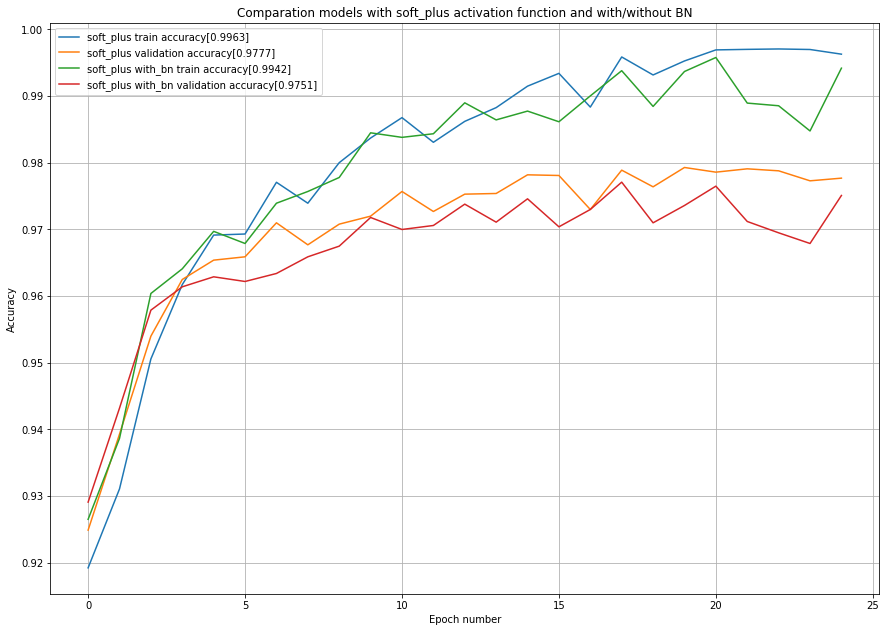

In [77]:
for k in act_bn_methods.keys():
    plt.figure(figsize=(29.7/2, 21./2))
    plt.title(f'Comparation models with {k} activation function and with/without BN')
    plt.xlabel("Epoch number")
    plt.ylabel("Accuracy")
    
    act_methods[k][1].visualize(independ_plot=False)
    act_bn_methods[k][1].visualize(independ_plot=False)
    
    plt.grid()
    plt.legend(loc='best')
    plt.show()

> Plot the losses for two networks: one trained by momentum_sgd, another one trained by Adam. Which one performs better?

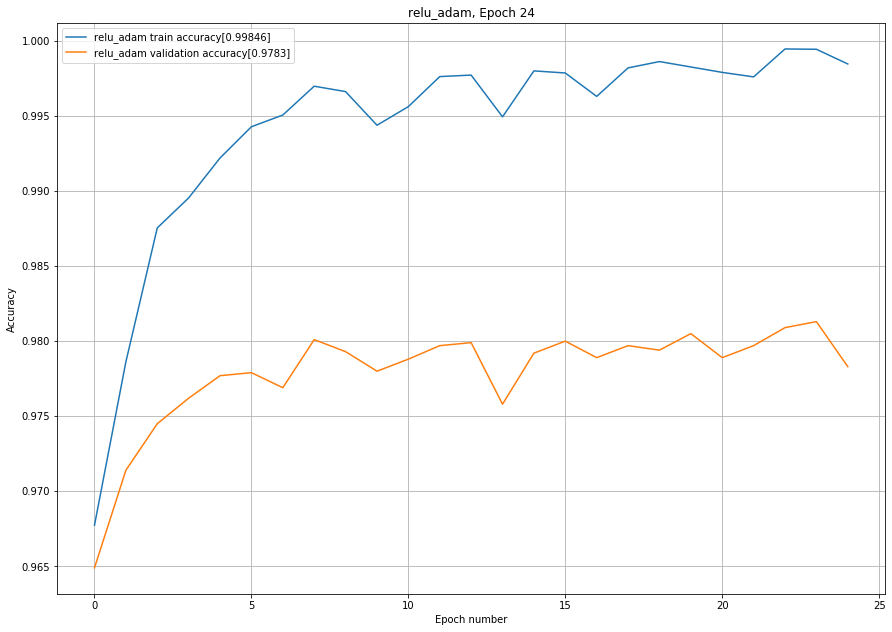

In [84]:
net = get_mlp(X_train.shape[1], 10, ReLU)
relu_sgd = Model(net, 'relu_sgd', ClassNLLCriterion())

net = get_mlp(X_train.shape[1], 10, ReLU)
relu_adam = Model(net, 'relu_adam', ClassNLLCriterion())

relu_sgd.fit(X_train, X_val, y_train_oh, y_train, y_val, sgd_momentum, optimizer_config={'learning_rate' : 0.1, 'momentum': 0.9})
relu_adam.fit(X_train, X_val, y_train_oh, y_train, y_val, adam_optimizer, optimizer_config={'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8})

display.clear_output(wait=True)

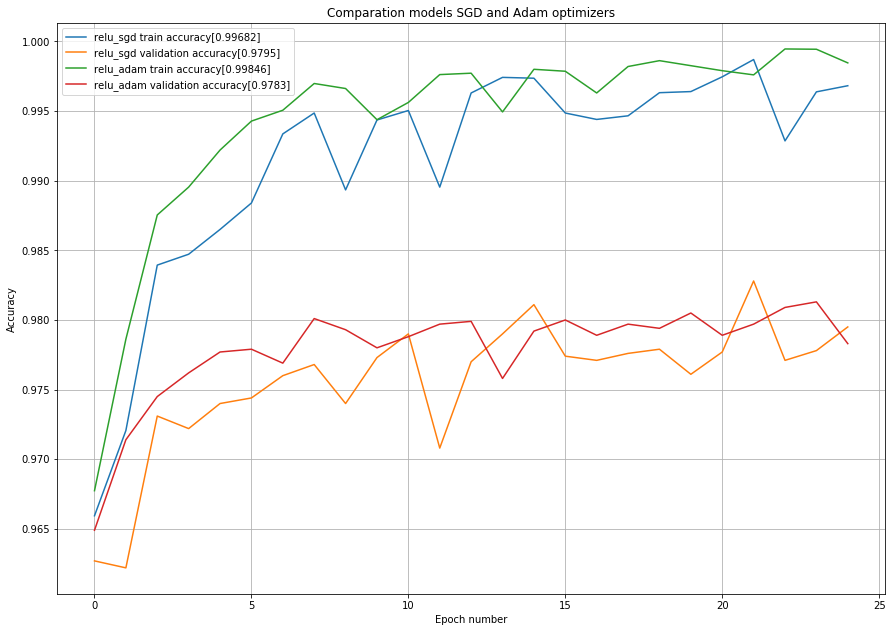

In [85]:
plt.figure(figsize=(29.7/2, 21./2))
plt.title(f'Comparation models SGD and Adam optimizers')
plt.xlabel("Epoch number")
plt.ylabel("Accuracy")

relu_sgd.visualize(independ_plot=False)
relu_adam.visualize(independ_plot=False)

plt.grid()
plt.legend(loc='best')
plt.show()

**Вывод:**

Видим, что при использовании ADAM наблюдается более быстрая сходимость. По этой причине он и популярен в практическом смысле. 

Write your personal opinion on the activation functions, think about computation times too. Does `BatchNormalization` help?

**Ответ:**

Можно заметить, что ReLU, ELU и LeakyReLU показывают похожие скорости сходимости и имеют близкую точность на валидационной выборке. В это же время активация SoftPlus дольше сходится и имеет меньшую точность. Мне кажется, что это происходит из-за затухания градиентов.

Хотя BatchNorm часто используется на практике(но никто не понимает почему он действительно работает и все попытки доказать что-либо заканчиваются провалом), в данной ситуации он не показал значительного прироста.

Что касается сравнения методов оптимизации, то ADAM продемонстрировал более высокую скорость сходимости относительно SGD, а общее время работы его эксперимента оказалось больше лишь потому, что не был реализован критерий остановки.

**Finally**, use all your knowledge to build a super cool model on this dataset. Use **dropout** to prevent overfitting, play with **learning rate decay**. You can use **data augmentation** such as rotations, translations to boost your score. Use your knowledge and imagination to train a model. Don't forget to call `training()` and `evaluate()` methods to set desired behaviour of `BatchNormalization` and `Dropout` layers.

In [94]:
# Architecture
net = Sequential()
net.add(Linear(X_train.shape[1], 500))
net.add(Dropout())
net.add(ReLU())
net.add(Linear(500, 250))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(250))
net.add(ReLU())
net.add(Linear(250, 10))
net.add(BatchNormalization())
net.add(ChannelwiseScaling(10))
net.add(LogSoftMax())

# Model
best = Model(net, 'best_model', ClassNLLCriterion())

In [95]:
%%time
best.fit(X_train, X_val, y_train_oh, y_train, y_val, adam_optimizer, optimizer_config={'learning_rate': 1e-3, 'beta1': 0.9, 'beta2':0.999, 'epsilon':1e-8}, batch_iterator=iterate_aug_minibatches)

NameError: name 'iaa' is not defined

Print here your accuracy on test set. It should be around 90%.

In [ ]:
print(np.mean(net.forward(X_test).argmax(axis=-1) == y_test))

### Comparing with PyTorch implementation
The last (and maybe the easiest step after compared to the previous tasks: build a network with the same architecture as above now with PyTorch.

You can refer to the `week0_09` or `Lab3_part2` notebooks for hints.

__Good Luck!__